# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *house.png*.
2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*).
Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zosanie podana wartość `0` (będą równe rozmiarowi).
3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj progowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

In [165]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import requests

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/'

fileNames = ["dom.png"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)



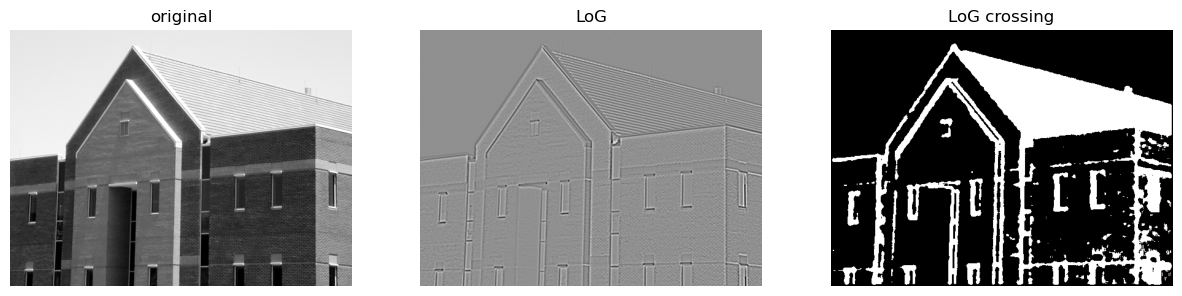

In [194]:
#1 
house = cv2.imread('dom.png', cv2.IMREAD_GRAYSCALE)

size = (5, 5)
sigma = 0

#2
house_blur = cv2.GaussianBlur(house, size, sigma)

#3
LoG = cv2.Laplacian(house_blur, cv2.CV_32F)

#4
def crossing(LoG, thr, filter_size):
  #4.1
  result = np.zeros_like(LoG)
  rows, cols = LoG.shape
  offset = filter_size // 2
  #4.2
  for i in range(offset, rows - offset):
    for j in range(offset, cols - offset):
      patch = LoG[i - offset:i + offset + 1, j - offset: j + offset + 1]
      min_v, max_v = patch.min(), patch.max()
      #4.3
      if min_v * max_v < 0:
        if LoG[i, j] > 0:
          result[i, j] = LoG[i, j] + abs(min_v)
        else:
          result[i, j] = abs(LoG[i, j]) + max_v
  #4.4
  result = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX)
  #4.5
  _, result = cv2.threshold(result, thr, 255, cv2.THRESH_BINARY)
  #4.6
  result = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX)
  #4.7
  result = np.uint8(result)
  #4.8
  result = cv2.medianBlur(result, 5)
  return result

LoG_cross = crossing(LoG, 30, 4)

def display_imgs(img1, img2, img3, title1="", title2="", title3=""):
  fig, axs = plt.subplots(1, 3, figsize=(15, 15))
  axs[0].imshow(img1, 'gray')
  axs[0].set_title(title1)
  axs[0].axis('off')
  axs[1].imshow(img2, 'gray')
  axs[1].set_title(title2)
  axs[1].axis('off')
  axs[2].imshow(img3, 'gray')
  axs[2].set_title(title3)
  axs[2].axis('off')
  plt.show()

display_imgs(house, LoG, LoG_cross, "original", "LoG", "LoG crossing")

## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w 1986r. przez Johna F. Cannego.
> Przy jego projektowaniu założono trzy cele:
> - niska liczba błędów - algorytm powinien znajdywać wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić jeden punkt dla każdej rzeczywistej krawędzi.

Zaimplementuj algorytm detekcji krawędziCanny'ego:
1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.
2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
Jedną z metod jest filtracja Sobela.
3. Dalej oblicz amplitudę:
$M(x,y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
$\alpha(x,y) = arctan(\frac{g_y}{g_x})$.
Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
Wynik jest w radianach.
4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:
[$-22.5^\circ, 22.5^\circ$], [$22.5^\circ, 67.5^\circ$],
[$67.5^\circ, 112.5^\circ$], [$112.5^\circ, 157.5^\circ$],
[$157.5^\circ, -157.5^\circ$], [$-157.5^\circ, -112.5^\circ$],
[$-112.5^\circ, -67.5^\circ$], [$-67.5^\circ, -22.5^\circ$].
Przy czym należy rozpatrywać tylko 4 kierunki:
    - pionowy ($d_1$),
    - poziomy ($d_2$),
    - skośny lewy ($d_3$),
    - skośny prawy ($d_4$).
5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. *nonmaximal suppresion*).
Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
Algorytm przebiega następująco.
W rozpatrywanym otoczeniu o rozmiarze $3 \times 3$:
    - określ do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$).
    - przeanalizuje sąsiadów leżących na tym kierunku.
Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
Zaimplementuj funkcję `nonmax`.
Pierwszym argementem jest macierz kierunków (po kwantyzacji).
Drugim argumentem jest macierz amplitudy.
6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
Stosuje się tutaj tzw. binaryzację z histerezą.
Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
Rezultaty binaryzacji można opisać jako:<br>
$g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
$g_{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
Często krawędzie "pewne" nie są ciągłe.
Dlatego wykorzystuje się obraz $g_{NL}$ w następującej procedurze:
    - Stwórz stos zawierający wszystkie piksele zaznaczone na obrazie $g_{NH}$.
W tym celu wykorzystaj listę współrzędnych `[row, col]`.
Do pobrania elementu z początku służy metoda `list.pop()`.
Do dodania elementu na koniec listy służy metoda `list.append(new)`.
    - Stwórz obraz, który będzie zawierał informację czy dany piksel został już odwiedzony.
    - Stwórz obraz, któy zawierać będzie wynikowe krawędzie.
Jej rozmiar jest równy rozmiarowi obrazu.
    - Wykonaj pętlę, która będzie pobierać elementy z listy, dopóki ta nie będzie pusta.
W tym celu najlepiej sprawdzi się pętla `while`.
    - W każdej iteracji pobierz element ze stosu.
    - Sprawdź czy dany element został już odwiedzony.
    - Jeśli nie został, to:
        - Oznacz go jako odwiedzony,
        - Oznacz piksel jako krawędź w wyniku,
        - Sprawdź otoczenie piksela w obrazie $g_{NL}$,
        - Dodaj do stosu współrzędne otoczenia, które zawierają krawędź (potencjalną).
        Można to wykoanać np. pętlą po stworzonym otoczeniu.
7. Wyświetl obraz oryginalny, obraz $g_{NH}$ oraz obraz wynikowy.

Pomocnicze obrazy $g_{NH}$ i $g_{NL}$ zostały wprowadzone dla uproszczenia opisu.
Algorytm można zaimplementować wbardziej "zwarty" sposób.

Na podstawie powyższego opisu zaimplementuj algorytm Cannego.

In [195]:
#5
def nonmax(quantized_angle, amplitude):
  gn = np.zeros_like(amplitude)
  rows, cols = amplitude.shape

  directions = {
      # vertical
      90: [[1, 1], 
          [0, 0]], # d1

      # horizontal
      0: [[0, 1],
          [0,  1]],
      180:[[0, 1],
          [0,  1]], # d2

      # right diagonal
      45:  [[0, 1], 
            [0, 0]], # d3

      # left diagonal
      135: [[1, 0], 
            [0, 0]]  # d4
  }

  for i in range(1, rows - 1):
    for j in range(1, cols - 1):
      direction = directions[abs(quantized_angle[i, j])]

      if amplitude[i, j] >= max(amplitude[i + direction[0][0], j + direction[0][1]], amplitude[i + direction[1][0], j + direction[1][1]]):
          gn[i, j] = amplitude[i, j]

  return gn

#6
def hysteresis_thresholding(gN, TL, TH):
  gNH = gN >= TH
  gNL = (gN < TH) & (gN >= TL)

  rows, cols = gN.shape
  stack = [(i, j) for i in range(rows) for j in range(cols) if gNH[i, j]]

  visited_pixels = np.zeros_like(gN, dtype=bool)
  edges = np.zeros_like(gN, dtype=bool)

  while stack:
    row, col = stack.pop()
    if not visited_pixels[row, col]:
      visited_pixels[row, col] = True
      edges[row, col] = True
      for i in range(row-1, row+2):
        for j in range(col-1, col+2):
          if gNL[i, j]:
            stack.append([i, j])

  return edges


def canny(image, TL, TH):
  #1
  gaussian_blur = cv2.GaussianBlur(image, size, sigma)

  #2 
  gx = cv2.Sobel(gaussian_blur, cv2.CV_64F, 1, 0, ksize=3)
  gy = cv2.Sobel(gaussian_blur, cv2.CV_64F, 0, 1, ksize=3)

  #3
  amplitude = np.sqrt(gx ** 2 + gy ** 2)
  radians = np.arctan2(gy, gx) # radians
  angle = np.rad2deg(radians) # degrees
  
  #4
  quantized_angle = np.zeros_like(angle)
  quantized_angle[np.where((angle >= -22.5) & (angle < 22.5))] = 0
  quantized_angle[np.where((angle >= 22.5) & (angle < 67.5))] = 45
  quantized_angle[np.where((angle >= 67.5) & (angle < 112.5))] = 90
  quantized_angle[np.where((angle >= 112.5) & (angle < 157.5))] = 135
  quantized_angle[np.where((angle >= 157.5) & (angle < - 157.5))] = 180
  quantized_angle[np.where((angle >= -157.5) & (angle < - 112.5))] = -135
  quantized_angle[np.where((angle >= -112.5) & (angle < - 67.5))] = -90
  quantized_angle[np.where((angle >= -67.5) & (angle < - 22.5))] = -45

  #5
  gn = nonmax(quantized_angle, amplitude)

  #6
  edges = hysteresis_thresholding(gn, TL, TH)

  return (gn, edges)

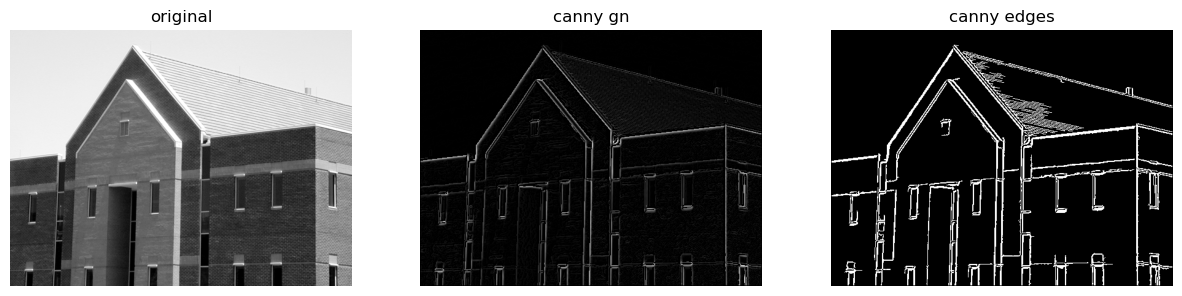

In [198]:
house_canny_gn, house_canny_edges = canny(house, 50, 150)
display_imgs(house, house_canny_gn, house_canny_edges, "original", "canny gn", "canny edges")

## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z własną implementacją.

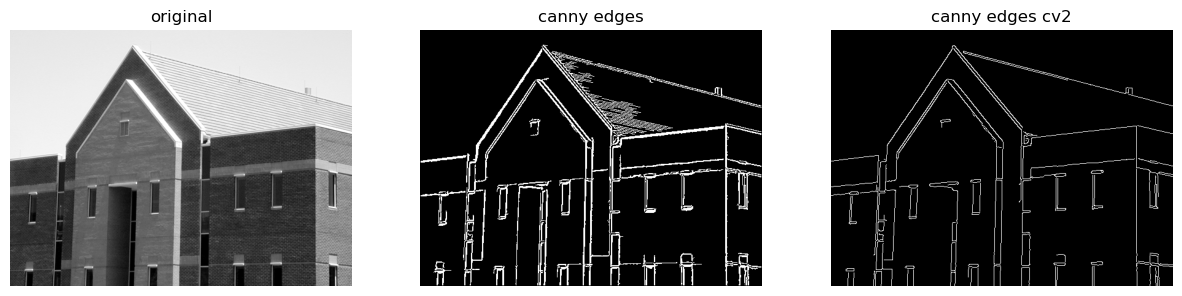

In [200]:
house = cv2.imread('dom.png', cv2.IMREAD_GRAYSCALE)
house_canny_gn, house_canny_edges = canny(house, 50, 150)
gaussian_blur = cv2.GaussianBlur(house, size, sigma)
edges_cv2 = cv2.Canny(gaussian_blur, 50, 150, None, 3, True)

display_imgs(house, house_canny_edges, edges_cv2, "original", "canny edges", "canny edges cv2")